In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
import tensorflow as tf

In [2]:
TRAIN_DIR = "/content/drive/MyDrive/Rice/Rice_Leaf_Diease/train"
TEST_DIR  = "/content/drive/MyDrive/Rice/Rice_Leaf_Diease/test"

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)


In [4]:
train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(128,128),
    batch_size=64,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(128,128),
    batch_size=64,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(128,128),
    batch_size=64,
    class_mode="categorical",
    shuffle=False
)

class_names = list(train_gen.class_indices.keys())
num_classes = len(class_names)
print("Classes:", class_names)

Found 10627 images belonging to 10 classes.
Found 2653 images belonging to 10 classes.
Found 1929 images belonging to 10 classes.
Classes: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot', 'neck_blast', 'rice_hispa', 'sheath_blight', 'tungro']


In [5]:
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(128,128,3))
for layer in base_model.layers:
    layer.trainable = False  # freeze base layers

x = base_model.output
x = Conv2D(32, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,632,170 (10.04 MB)

 Trainable params: 374,186 (1.43 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 3856s 23s/step - accuracy: 0.4848 - loss: 1.5007 - val_accuracy: 0.7897 - val_loss: 0.6197
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 557s 3s/step - accuracy: 0.7933 - loss: 0.5940 - val_accuracy: 0.8296 - val_loss: 0.4842
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 540s 3s/step - accuracy: 0.8395 - loss: 0.4433 - val_accuracy: 0.8413 - val_loss: 0.4457
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 521s 3s/step - accuracy: 0.8718 - loss: 0.3728 - val_accuracy: 0.8734 - val_loss: 0.3853
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 512s 3s/step - accuracy: 0.8953 - loss: 0.2972 - val_accuracy: 0.8828 - val_loss: 0.3204
Epoch 6/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 522s 3s/step - accuracy: 0.9123 - loss: 0.2496 - val_accuracy: 0.8907 - val_loss: 0.2970
Epoch 7/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 515s 3s/step - accuracy: 0.9165 - loss: 0.2317 - val_accuracy: 0.8843 - val_loss: 0.3326
Epoch 8/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 519s 3s/step - accuracy: 0.9188 - loss: 0.2289 - val_ac

In [7]:
model.save("/content/drive/MyDrive/rice_leaf_hybrid_mobilenetv2_final.h5")

In [8]:
test_loss, test_accuracy = model.evaluate(test_gen)
print("\nTest Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

31/31 ━━━━━━━━━━━━━━━━━━━━ 547s 18s/step - accuracy: 0.9093 - loss: 0.2818

Test Loss: 0.2216033637523651
Test Accuracy: 0.9305339455604553


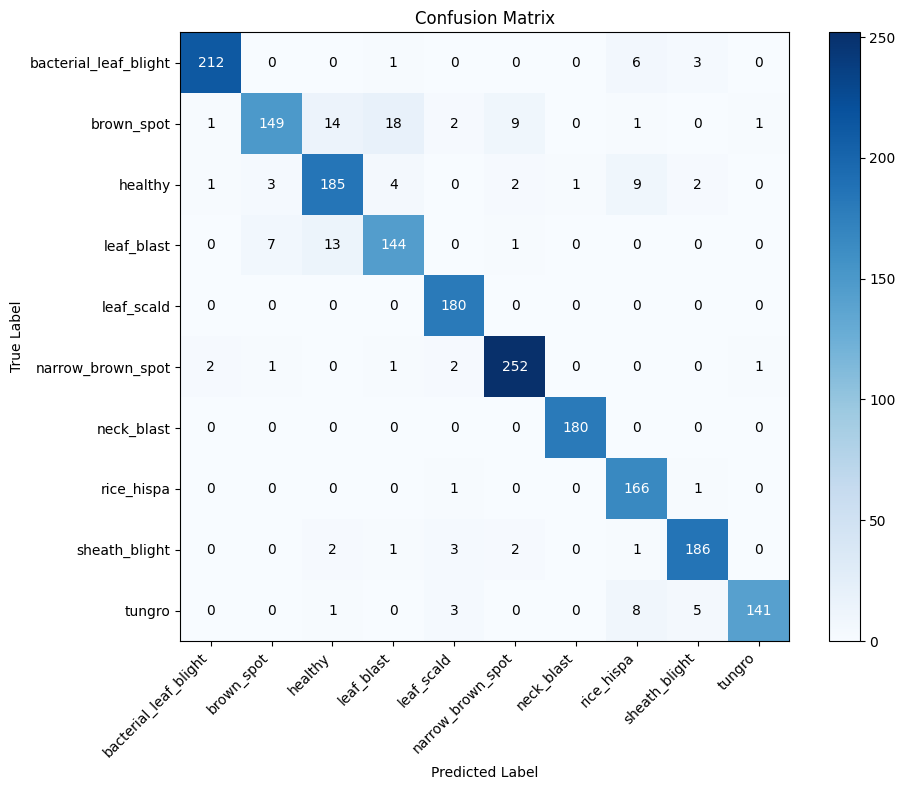

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(np.arange(len(class_names)), class_names)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")

thresh = cm.max() / 2.0
for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()


In [11]:
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall    = recall_score(y_true, y_pred, average="weighted")
f1        = f1_score(y_true, y_pred, average="weighted")

print("\n=== MODEL PERFORMANCE METRICS ===")
print("Accuracy   :", accuracy)
print("Precision  :", precision)
print("Recall     :", recall)
print("F1-Score   :", f1)
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))



=== MODEL PERFORMANCE METRICS ===
Accuracy   : 0.9305339554173147
Precision  : 0.9321464198155535
Recall     : 0.9305339554173147
F1-Score   : 0.9298131411805168

Classification Report:

                       precision    recall  f1-score   support

bacterial_leaf_blight       0.98      0.95      0.97       222
           brown_spot       0.93      0.76      0.84       195
              healthy       0.86      0.89      0.88       207
           leaf_blast       0.85      0.87      0.86       165
           leaf_scald       0.94      1.00      0.97       180
    narrow_brown_spot       0.95      0.97      0.96       259
           neck_blast       0.99      1.00      1.00       180
           rice_hispa       0.87      0.99      0.92       168
        sheath_blight       0.94      0.95      0.95       195
               tungro       0.99      0.89      0.94       158

             accuracy                           0.93      1929
            macro avg       0.93      0.93      0.93  

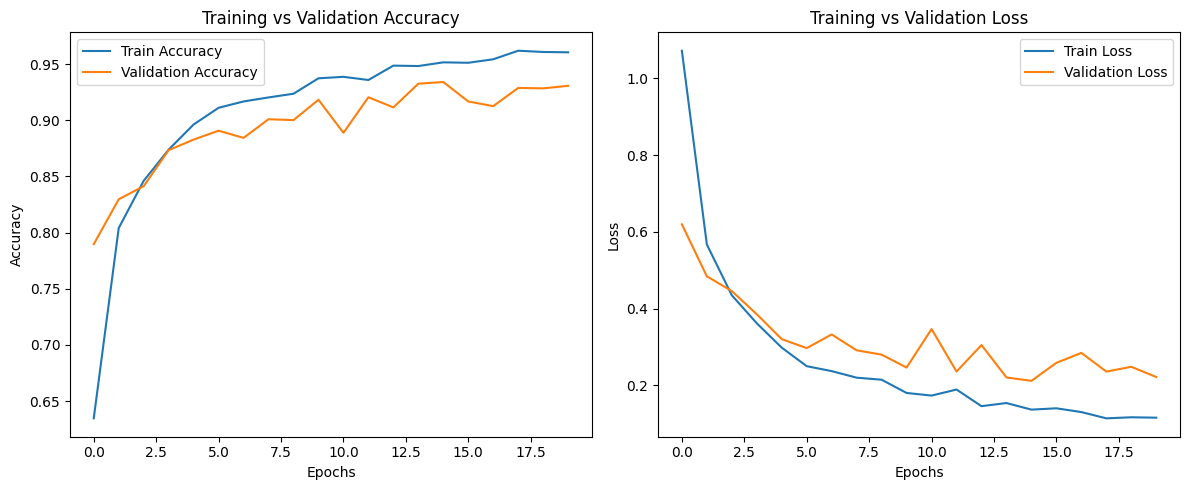

In [12]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.tight_layout()
plt.show()

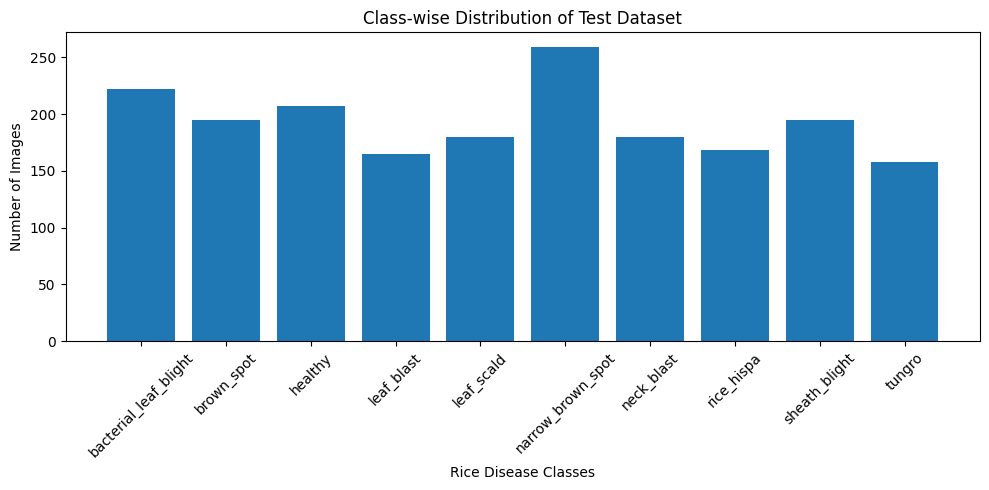

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

class_names = list(test_gen.class_indices.keys())
class_counts = pd.Series(test_gen.classes).value_counts().sort_index()

plt.figure(figsize=(10,5))
plt.bar(class_names, class_counts.values)
plt.xticks(rotation=45)
plt.xlabel("Rice Disease Classes")
plt.ylabel("Number of Images")
plt.title("Class-wise Distribution of Test Dataset")
plt.tight_layout()
plt.show()


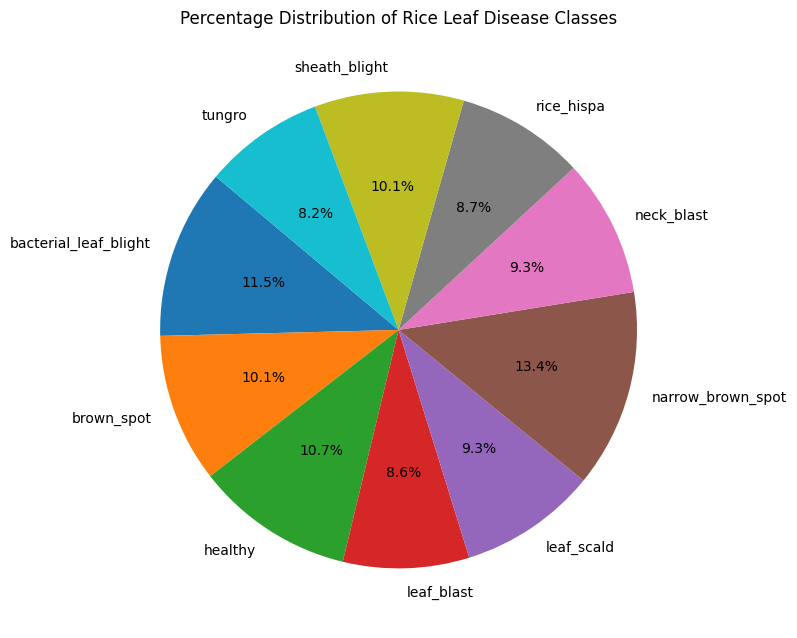

In [15]:
plt.figure(figsize=(8,8))
plt.pie(
    class_counts.values,
    labels=class_names,
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Percentage Distribution of Rice Leaf Disease Classes")
plt.tight_layout()
plt.show()


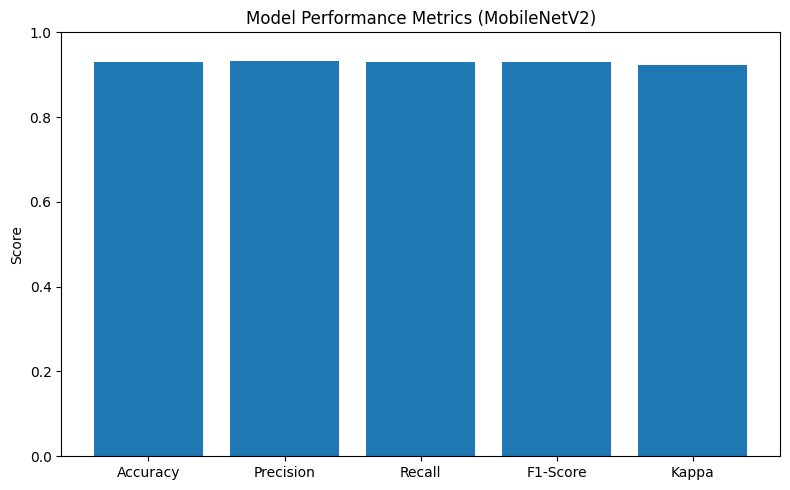

In [18]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(y_true, y_pred)
metrics_names = ["Accuracy", "Precision", "Recall", "F1-Score", "Kappa"]
metrics_values = [accuracy, precision, recall, f1, kappa]

plt.figure(figsize=(8,5))
plt.bar(metrics_names, metrics_values)
plt.ylim(0,1)
plt.title("Model Performance Metrics (MobileNetV2)")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


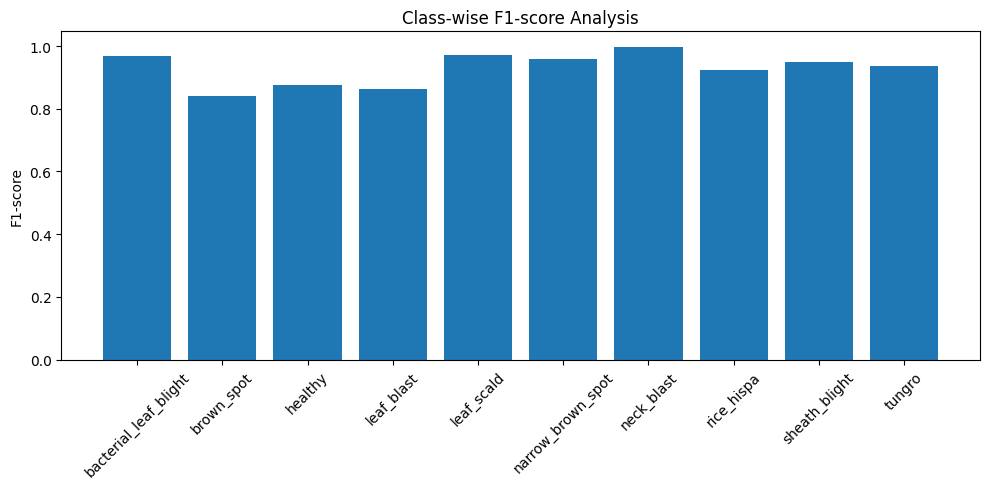

In [19]:
from sklearn.metrics import classification_report

report = classification_report(
    y_true, y_pred,
    target_names=class_names,
    output_dict=True
)

f1_scores = [report[c]["f1-score"] for c in class_names]

plt.figure(figsize=(10,5))
plt.bar(class_names, f1_scores)
plt.xticks(rotation=45)
plt.ylabel("F1-score")
plt.title("Class-wise F1-score Analysis")
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step

Predicted Class: neck_blast

Class Probabilities:
bacterial_leaf_blight: 0.00%
brown_spot: 0.00%
healthy: 0.00%
leaf_blast: 0.00%
leaf_scald: 0.00%
narrow_brown_spot: 0.00%
neck_blast: 100.00%
rice_hispa: 0.00%
sheath_blight: 0.00%
tungro: 0.00%

Using last convolutional layer: conv2d


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


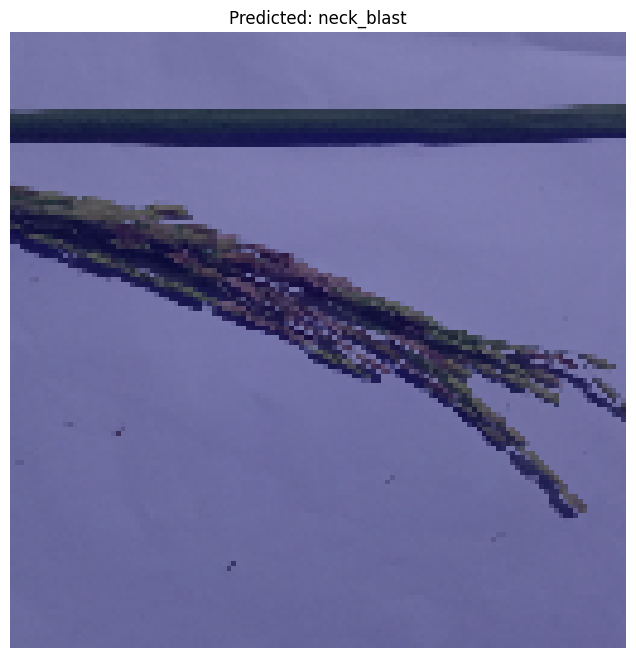

In [25]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

img_path = "/content/drive/MyDrive/Rice/Rice_Leaf_Diease/test/neck_blast/IMG20201109211732_00.jpg"

IMG_SIZE = (128, 128)
img = image.load_img(img_path, target_size=IMG_SIZE)
img_array = image.img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)
class_index = np.argmax(preds[0])
predicted_class = class_names[class_index]

print(f"\nPredicted Class: {predicted_class}\n")
print("Class Probabilities:")
for i, name in enumerate(class_names):
    print(f"{name}: {preds[0][i]*100:.2f}%")

for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

print(f"\nUsing last convolutional layer: {last_conv_layer_name}")

def get_gradcam_heatmap(model, img_array, class_index, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap) + 1e-8

    return heatmap.numpy()

heatmap = get_gradcam_heatmap(model, img_array, class_index, last_conv_layer_name)

heatmap_resized = cv2.resize(heatmap, IMG_SIZE)
heatmap_resized = np.uint8(255 * heatmap_resized)

heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

img_orig = cv2.imread(img_path)
img_orig = cv2.resize(img_orig, IMG_SIZE)

superimposed_img = cv2.addWeighted(img_orig, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()


In [28]:
import json
from tensorflow.keras.models import load_model

model.save("/content/drive/MyDrive/rice_leaf_hybrid_mobilenetv2_final.keras")
print("Model saved successfully in .keras format")

CLASS_NAMES_PATH = "/content/drive/MyDrive/rice_leaf_class_names.json"
with open(CLASS_NAMES_PATH, "w") as f:
    json.dump(class_names, f)
print("Class names saved successfully")


Model saved successfully in .keras format
Class names saved successfully
